In [1]:
import numpy as np
from typing import List, Tuple, Iterable, Any
import matplotlib.pyplot as plt
import pandas as pd
import pint
from uncertainties.core import Variable
import cobra
import seaborn as sns
import cobra.exceptions
from cobra.io import read_sbml_model
from cobra.flux_analysis import pfba, phenotype_phase_plane, flux_variability_analysis
import escher
from urllib.request import urlopen

plt.rcParams["font.family"] = "DejaVu Sans"
Q_ = pint.UnitRegistry()

def confidence_interval(x: Variable) -> Tuple[float, float]:
    """Get the minimum and maximum value assuming one standard deviation."""
    return (x.nominal_value - x.std_dev, x.nominal_value + x.std_dev)

def plot_envelope(
        model: cobra.core.model,
        target_reaction: str,
        ax: plt.Axes,
        label: str = None,
        color: Any = 'b',
        points: int = 20):
    prod_env_df = phenotype_phase_plane.production_envelope(model, target_reaction, points=points)

    ax.plot(prod_env_df.flux_minimum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=1, label='')
    ax.plot(prod_env_df.flux_maximum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=1, label='')

    ax.fill_betweenx(
        prod_env_df[target_reaction],
        prod_env_df.flux_minimum,
        prod_env_df.flux_maximum,
        linewidth=0,
        alpha=0.4,
        facecolor=color,
        label=label)
    target_rxn = model.reactions.get_by_id(target_reaction)
    
    ax.set_xlabel(model.objective.expression)
    ax.set_ylabel(target_rxn.name)
    
    # calculate the slope
    old_bounds = target_rxn.bounds
    target_rxn.bounds = (1e-3, 1e-3)
    sol = model.optimize("maximize")
    if sol.objective_value > 0:
        slope = 1e-3 / sol.objective_value
    else:
        slope = np.nan
    target_rxn.bounds = old_bounds
    return slope
    

In [2]:
wt_model = read_sbml_model("iML1515.xml")
# fix errors in the iML1515 model
wt_model.remove_reactions(["POR5", "GLYCK"]) # these reactions are not present in E. coli
wt_model.reactions.THD2pp.add_metabolites({"h_p": 1, "h_c": -1}) # transhydrogenase translocates only 1 proton (not 2)

cobra\core\group.py:109 UserWarning: need to pass in a list


In [3]:
# knock out PFL and OBTFL are removed to simulate aerobic conditions
model_methanotroph = wt_model.copy()
model_methanotroph.reactions.PFL.knock_out()
model_methanotroph.reactions.OBTFL.knock_out()

# based on gathered evidence, we remove FTHFLi (that uses formate to charge THF)
model_methanotroph.reactions.FTHFLi.knock_out()

# Formyltetrahydrofolate deformylase should be irreversible 10fthf_c + h2o_c --> for_c + h_c + thf_c  
model_methanotroph.reactions.FTHFD.bounds = (0.0, 1000.0)

# GARFT and AICART are also forced to be irreversible, so that 10fthf won't be created from nucleotide degradation
model_methanotroph.reactions.GARFT.bounds = (0.0, 1000.0)
model_methanotroph.reactions.AICART.bounds = (0.0, 1000.0)

# GART (GAR transformylase-T) uses formate directly to synthesize purines, which we want prevent in our model
model_methanotroph.reactions.GART.bounds = (0.0, 0.0)

# we change the thymidine periplasmic symporter reaction to be reversible,
# based on evidence for it (adding thymidine to the media rescues growth for certain conditions).
model_methanotroph.reactions.THYMt3pp.bounds = (-1000.0, 1000.0)

# add the spontaneous reaction from THF + formaldehyde -> methylene-THF
rxn = cobra.Reaction(id="THFSPONT", name="spontaneous condensation of THF and formaldehyde", lower_bound=0, upper_bound=1000)
model_methanotroph.add_reaction(rxn)
rxn.add_metabolites({"thf_c": -1, "fald_c": -1, "mlthf_c": 1, "h2o_c": 1})

# add FDH (formate NAD dehydrogenase) to efficiently utilize the formate create from formaldehyde
rxn = cobra.Reaction(id="FDH", name="formate NAD dehydrogeanse", lower_bound=0, upper_bound=1000)
model_methanotroph.add_reaction(rxn)
rxn.add_metabolites({"for_c": -1, "nad_c": -1, "co2_c": 1, "nadh_c": 1})

# adding reactions required for the ethylmalonyl-CoA cycle
rxn = cobra.Reaction(id="EtMaCoA", name="Crotonoyl-CoA carboxylase", lower_bound=0, upper_bound=1000)
model_methanotroph.add_reaction(rxn)
rxn.add_metabolites({"b2coa_c": -1, "nadph_c": -1, "co2_c": -1, "q8_c": -1, "h2o_c": -1,
                     "glx_c": 1, "ppcoa_c": 1, "nadp_c": 1, "q8h2_c": 1})

# adding reactions required for recycling the ppcoa_c (Propionyl-CoA) created by EtMaCoA
rxn = cobra.Reaction(id="MMCDr", name="Methylmalonyl-CoA decarboxylase (reverse)", lower_bound=0, upper_bound=1000)
model_methanotroph.add_reaction(rxn)
rxn.add_metabolites({"ppcoa_c": -1, "atp_c": -1, "hco3_c": -1,
                     "mmcoa__S_c": 1, "adp_c": 1, "h_c": 1, "pi_c": 1})

# MMM (Methylmalonyl-CoA mutase) is made reversible so that the mmcoa_c (methylmalonyl-CoA) can be recycled
model_methanotroph.reactions.MMM.bounds = (-1000, 1000)

# add the reactions of the serine cycle (SGAT, MTK, and MCL)
rxn = cobra.Reaction(id="SGAT1", name="serine-hydroxypyruvate amino-transferase", lower_bound=-1000, upper_bound=1000)
model_methanotroph.add_reaction(rxn)
rxn.add_metabolites({"ser__L_c": -1, "akg_c": -1,
                     "glu__L_c": 1, "hpyr_c": 1})

rxn = cobra.Reaction(id="SGAT2", name="glycine-glyoxylate amino-transferase", lower_bound=-1000, upper_bound=1000)
model_methanotroph.add_reaction(rxn)
rxn.add_metabolites({"gly_c": -1, "akg_c": -1,
                     "glx_c": 1, "glu__L_c": 1})

met = cobra.Metabolite(id="malylcoa_c", formula="C25H35N7O20P3S", name="(S)-Malyl-CoA", charge=-5,
                       compartment="c")
model_methanotroph.add_metabolites([met])

rxn = cobra.Reaction(id="MTK", name="malate thiokinase", lower_bound=0, upper_bound=1000)
model_methanotroph.add_reaction(rxn)
rxn.add_metabolites({"mal__L_c": -1, "atp_c": -1, "coa_c": -1,
                     "malylcoa_c": 1, "adp_c": 1, "pi_c": 1})

rxn = cobra.Reaction(id="MCL", name="malyl-CoA lyase", lower_bound=0, upper_bound=1000)
model_methanotroph.add_reaction(rxn)
rxn.add_metabolites({"malylcoa_c": -1,
                     "accoa_c": 1, "glx_c": 1})

# remove GLXCL and GLYCL to get rid of a potential carbon fixation cycle.
# since we really only want methanol to be the carbon source (not CO2).
model_methanotroph.reactions.GLXCL.knock_out()
model_methanotroph.reactions.GLYCL.knock_out()
model_methanotroph.reactions.THRD.knock_out()
model_methanotroph.reactions.THRA2.knock_out()
model_methanotroph.reactions.THRA.knock_out()
model_methanotroph.reactions.SERD_L.knock_out()

In [4]:
model_methanotroph.reactions.EX_glc__D_e.bounds = (0.0, 1000.0)
model_methanotroph.reactions.EX_fald_e.bounds = (-10, 1000)

THFSPONT_flux = Q_.Measurement(0.0252, 0.0035, "mmol/gram/hour")

model_methanotroph.reactions.THFSPONT.bounds = (THFSPONT_flux.magnitude.nominal_value, THFSPONT_flux.magnitude.nominal_value)
sol = model_methanotroph.optimize()
max_gr = sol['BIOMASS_Ec_iML1515_core_75p37M']

model_methanotroph.reactions.THFSPONT.bounds = confidence_interval(THFSPONT_flux)
sol = model_methanotroph.optimize()
max_gr_error = sol['BIOMASS_Ec_iML1515_core_75p37M'] - max_gr

max_gr = Q_.Measurement(max_gr, max_gr_error, "1/hour")
dt = np.log(2) / max_gr  # in hour
print(f"Doubling time = {dt.to('day'):.2f}")


Doubling time = (23.50 +/- 3.26) day


In [5]:
# check if EX_fald_e limits the model
model_methanotroph.metabolites.get_by_id('fald_c').summary()

PRODUCING REACTIONS -- Formaldehyde (fald_c)
--------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  ----------------------------
100%    2.92  FALDtpp   fald_p <=> fald_c

CONSUMING REACTIONS -- Formaldehyde (fald_c)
--------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  ----------------------------
99%     2.89  FALGTHLs  fald_c + gthrd_c <=> hmgth_c


Text(0.5, 1.0, 'Phenotypic phase plane')

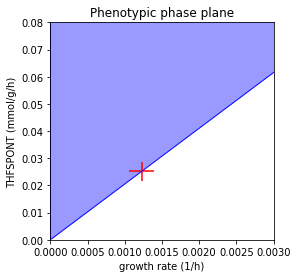

In [6]:
# not really, then do PPP and plot
model_methanotroph.reactions.THFSPONT.bounds = (0.0, 0.1)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_envelope(model_methanotroph, "THFSPONT", ax)
ax.set_xlabel("growth rate (1/h)")
ax.set_ylabel(f"THFSPONT (mmol/g/h)")
ax.set_ylim(0, 0.08)
ax.set_xlim(0, 0.003)
ax.errorbar(max_gr.magnitude.nominal_value,
            THFSPONT_flux.magnitude.nominal_value,
            xerr=max_gr.magnitude.std_dev,
            yerr=THFSPONT_flux.magnitude.std_dev,
            color="r")
ax.set_title("Phenotypic phase plane")

In [7]:
fig.savefig('PPP_THFSPONT4serine_cycle.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
